<a href="https://colab.research.google.com/github/sepety/RL_Otus/blob/main/%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_DQN_%D1%81_%D1%80%D0%B5%D0%BF%D0%BB%D0%B5%D0%B9_%D0%B1%D1%83%D1%84%D1%84%D0%B5%D1%80%D0%BE%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**алгоритм DQN с реплей буффером и мягким обновлением целевой сети**

In [2]:
# @title установка драйверов
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install xvfb > /dev/null 2>&1

In [3]:
# @title установка библиотек
%%capture
!pip install rarfile --quiet
!pip install stable-baselines3[extra] --quiet
!pip install ale-py --quiet
!pip install gym[box2d] --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet --quiet
!pip install pygame --quiet
!pip install minigrid --quiet
!pip install -q swig --quiet
!pip install -q gymnasium[box2d] --quiet
!pip install 'minigrid<=2.1.1' --quiet
!pip3 install box2d-py --quiet


In [4]:
# Imports
import io
import os
import glob
import torch
import base64

import numpy as np
import matplotlib.pyplot as plt

import sys
import gymnasium
sys.modules["gym"] = gymnasium

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gymnasium as gym
from gym import spaces
from gym.envs.box2d.lunar_lander import *
from gym.wrappers.monitoring.video_recorder import VideoRecorder

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [18]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Для отображения видео в Google Colab
from pyvirtualdisplay import Display
import base64
import glob
import io
import os
from IPython.display import HTML, display

# Инициализируем виртуальный дисплей
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()



**Настройка устройства (CPU или GPU)**

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")


Используемое устройство: cuda


**Создание среды LunarLander**

In [7]:
env = gym.make("LunarLander-v2")


Параметры среды:

In [8]:
state, _ = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

print(f"Размерность пространства состояний: {n_observations}")
print(f"Количество возможных действий: {n_actions}")


Размерность пространства состояний: 8
Количество возможных действий: 4


**Определение нейронной сети DQN**

In [9]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # Полносвязные слои
        self.fc1 = nn.Linear(n_observations, 128)    # Входной слой
        self.fc2 = nn.Linear(128, 128)               # Скрытый слой
        self.fc3 = nn.Linear(128, n_actions)         # Выходной слой

    def forward(self, x):
      # Прямое распространение
        x = F.relu(self.fc1(x))  # Применяем ReLU активацию после первого слоя
        x = F.relu(self.fc2(x))  # Применяем ReLU активацию после второго слоя
        return self.fc3(x)       # Выходной слой без активации


**Реализация реплей буфера**

In [ ]:
# Именованный кортеж для хранения переходов
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Класс для реплей буфера
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)  # Двухсторонняя очередь с ограниченной максимальной длиной

    def push(self, *args):
        """Сохраняет переход в память"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Возвращает случайный мини-батч переходов"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


**Определение ε-жадной стратегии выбора действий**

In [ ]:
# Параметры ε-жадной стратегии
EPS_START = 0.9     # Начальное значение ε
EPS_END = 0.05      # Минимальное значение ε
EPS_DECAY = 1000    # Скорость экспоненциального снижения ε

steps_done = 0  # Счетчик выполненных шагов

def select_action(state):
    """Выбирает действие на основе ε-жадной стратегии"""
    global steps_done
    sample = random.random()
    # Вычисляем текущее значение ε
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # Выбираем действие с максимальным Q-значением (эксплуатация)
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Выбираем случайное действие (исследование)
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


**Реализация функции обучения модели**

In [ ]:
# Гиперпараметры обучения
BATCH_SIZE = 128    # Размер мини-батча
GAMMA = 0.99        # Коэффициент дисконтирования будущих наград
TAU = 0.005         # Скорость мягкого обновления целевой сети
LR = 1e-4           # Скорость обучения

# Инициализируем нейронные сети и оптимизатор
policy_net = DQN(n_observations, n_actions).to(device)   # Основная сеть
target_net = DQN(n_observations, n_actions).to(device)   # Целевая сеть
target_net.load_state_dict(policy_net.state_dict())      # Копируем веса основной сети в целевую
target_net.eval()                                        # Устанавливаем режим оценки для целевой сети

optimizer = optim.Adam(policy_net.parameters(), lr=LR)   # Оптимизатор Adam
memory = ReplayMemory(10000)                             # Инициализируем реплей буфер

def optimize_model():
    """Функция обучения модели на одном мини-батче"""
    if len(memory) < BATCH_SIZE:
        # Ждем, пока в буфере накопится достаточное количество переходов
        return

    # Выбираем случайный мини-батч из реплей буфера
    transitions = memory.sample(BATCH_SIZE)
    # Преобразуем список переходов в Transition of batch-arrays
    batch = Transition(*zip(*transitions))

    # Создаем маску для неконечных следующих состояний (not None)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device, dtype=torch.bool)

    # Соединяем неконечные следующие состояния в один тензор
    non_final_next_states = torch.cat([s for s in batch.next_state
                                        if s is not None]).to(device)

    # Соединяем состояния, действия и награды в тензоры
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    # Вычисляем Q(s_t, a) с помощью основной сети
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Инициализируем тензор для хранения следующих Q-значений
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # Для всех неконечных состояний вычисляем V(s_{t+1}) = max_a' Q(s_{t+1}, a')
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Вычисляем ожидаемые Q-значения
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.squeeze()

    # Вычисляем функцию потерь (Smooth L1 Loss)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values.squeeze(), expected_state_action_values)

    # Выполняем шаг оптимизации
    optimizer.zero_grad()
    loss.backward()
    # Ограничиваем градиенты для предотвращения взрывных градиентов
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


**Основной цикл обучения агента**

In [ ]:
num_episodes = 500  # Общее количество эпизодов для обучения
episode_durations = []  # Список для хранения длительностей эпизодов
episode_rewards = []    # Список для хранения суммарных наград за эпизод

for i_episode in range(num_episodes):
    # Сбрасываем среду и получаем начальное состояние
    state, _ = env.reset()
    state = torch.tensor([state], dtype=torch.float32).to(device)
    total_reward = 0  # Инициализируем суммарную награду для текущего эпизода

    for t in count():
        # Выбираем действие на основе текущего состояния
        action = select_action(state)
        # Выполняем действие в среде
        observation, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward  # Обновляем суммарную награду
        reward = torch.tensor([reward], device=device)

        # Проверяем, завершен ли эпизод
        done = terminated or truncated

        if not done:
            # Преобразуем следующее состояние в тензор
            next_state = torch.tensor([observation], dtype=torch.float32).to(device)
        else:
            next_state = None  # Если эпизод завершен, следующего состояния нет

        # Сохраняем переход в реплей буфер
        memory.push(state, action, next_state, reward)
        # Обновляем текущее состояние
        state = next_state

        # Обучаем модель
        optimize_model()

        # Мягкое обновление параметров целевой сети
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = TAU * policy_net_state_dict[key] + \
                                         (1 - TAU) * target_net_state_dict[key]
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # Сохраняем длительность и награду эпизода
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)
            if (i_episode + 1) % 10 == 0:
                print(f"Эпизод {i_episode + 1}/{num_episodes}, Продолжительность: {t + 1}, Награда: {total_reward:.2f}")
            break  # Переходим к следующему эпизоду

print('Обучение завершено')


Визуализация результатов обучения

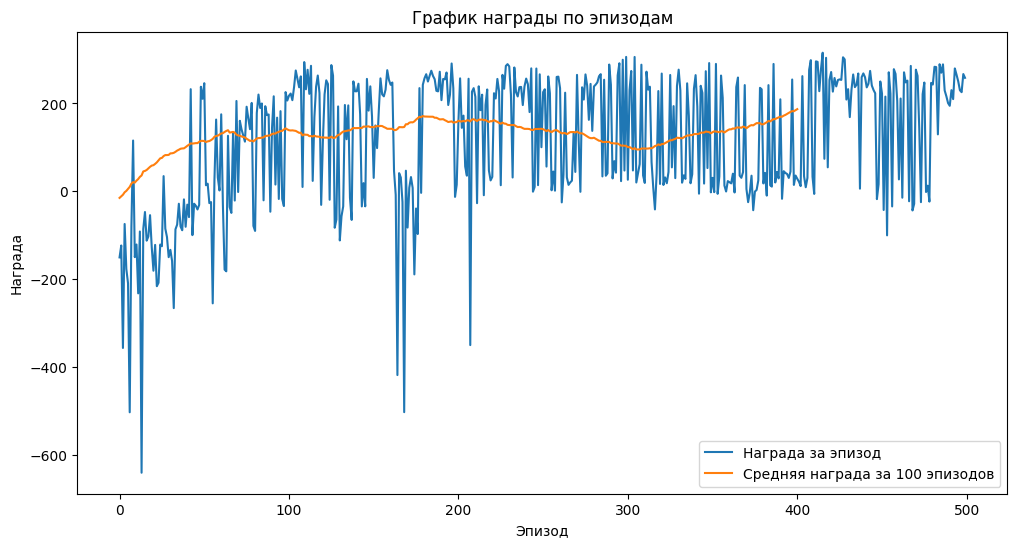

In [21]:
# Вычисляем скользящее среднее
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Награда за эпизод')
if len(episode_rewards) >= 100:
    plt.plot(moving_average(episode_rewards, 100), label='Средняя награда за 100 эпизодов')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('График награды по эпизодам')
plt.legend()
plt.show()


Сохранение и загрузка обученной модели

In [26]:
# Сохранение модели
torch.save(policy_net.state_dict(), 'dqn_lunarlander.pth')


In [27]:
# Загрузка модели
policy_net = DQN(n_observations, n_actions).to(device)
policy_net.load_state_dict(torch.load('dqn_lunarlander.pth'))
policy_net.eval()


<ipython-input-27-9dcd02a3369c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load('dqn_lunarlander.pth'))


DQN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

Тестирование обученного агента
python

In [28]:
from IPython.display import HTML, display


In [29]:
# Функция для отображения видео
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''
            <video width="640" height="480" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4">
            </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Видео не найдено")

from gymnasium.wrappers import RecordVideo

env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = RecordVideo(env, video_folder='video', episode_trigger=lambda x: True)

state, _ = env.reset()
state = torch.tensor([state], dtype=torch.float32).to(device)
total_reward = 0

for t in count():
    with torch.no_grad():
        action = policy_net(state).max(1)[1].view(1, 1)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    total_reward += reward

    done = terminated or truncated

    if not done:
        next_state = torch.tensor([observation], dtype=torch.float32).to(device)
    else:
        next_state = None

    state = next_state

    if done:
        print(f"Тестовый эпизод завершен. Продолжительность: {t + 1}, Награда: {total_reward:.2f}")
        break

env.close()
show_video()


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Тестовый эпизод завершен. Продолжительность: 1000, Награда: 107.11
